#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [1]:
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [2]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

# Importamos las librerias necesarias para los experimentos

In [3]:
import pandas
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import glob

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



Ejemplo de salida de una imágen luego de aplicada la transformación Adaptativa

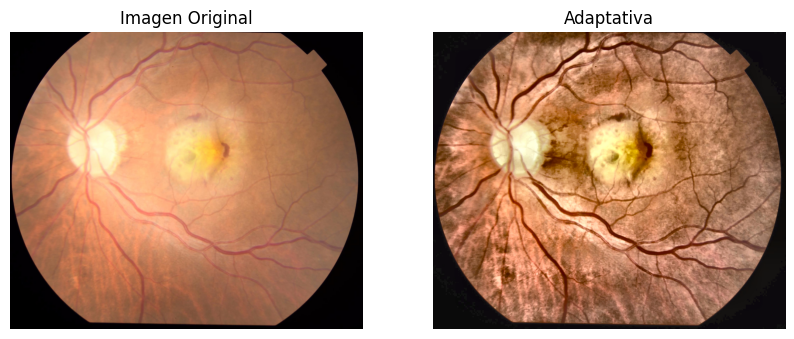

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import exposure

image_path = '/content/DS_TFE_Final/test/Macular_Scar/Macular Scar125-flip.jpg'
image = cv2.imread(image_path)

if image.dtype == np.float32 or image.dtype == np.float64:
    image = (image * 255).astype(np.uint8)

lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
l_channel, a_channel, b_channel = cv2.split(lab_image)
l_channel_eq = exposure.equalize_adapthist(l_channel, clip_limit=0.03)
l_channel_eq_uint8 = (255 * l_channel_eq).astype(np.uint8)
lab_image_eq = cv2.merge((l_channel_eq_uint8, a_channel, b_channel))
image_eq = cv2.cvtColor(lab_image_eq, cv2.COLOR_LAB2RGB)

# Mostrar la imagen original y la imagen con transf. adaptativa
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Adaptativa')
plt.imshow(cv2.cvtColor(image_eq, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [4]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Función para convertir la imágen aplicando el filtro Adaptativa.
Esta función se ejecuta al momento de procesar las imagenes en el entrenamiento mediante el ImageDataGenerator

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import exposure

def preprocessing_image(image):
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)

    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_channel_eq = exposure.equalize_adapthist(l_channel, clip_limit=0.03)
    l_channel_eq_uint8 = (255 * l_channel_eq).astype(np.uint8)
    lab_image_eq = cv2.merge((l_channel_eq_uint8, a_channel, b_channel))
    image_eq = cv2.cvtColor(lab_image_eq, cv2.COLOR_LAB2RGB)
    image_eq_resized = cv2.resize(image_eq, (224,224))
    image_eq_preprocessed = preprocess_input(image_eq_resized.astype(np.float32))

    return image_eq_preprocessed

## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
val_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
test_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

input_shape = (224, 224, 3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [7]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(12,12))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(12,12))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [9]:
from sklearn.metrics import classification_report
def calcular_metricas_por_clase(y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [10]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model1 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model1.layers:
    layer.trainable = False

model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(6, activation='softmax'))


# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 112s 946ms/step - loss: 1.1308 - accuracy: 0.5510 - precision: 0.7341 - recall: 0.3685 - auc: 0.8673 - val_loss: 0.8846 - val_accuracy: 0.6441 - val_precision: 0.7705 - val_recall: 0.5142 - val_auc: 0.9217
Epoch 2/20
100/100 [==============================] - 129s 1s/step - loss: 0.8293 - accuracy: 0.6935 - precision: 0.7977 - recall: 0.5600 - auc: 0.9308 - val_loss: 0.9213 - val_accuracy: 0.6396 - val_precision: 0.7392 - val_recall: 0.5598 - val_auc: 0.9157
Epoch 3/20
100/100 [==============================] - 114s 1s/step - loss: 0.7536 - accuracy: 0.7023 - precision: 0.7921 - recall: 0.5969 - auc: 0.9428 - val_loss: 0.7785 - val_accuracy: 0.7104 - val_precision: 0.7851 - val_recall: 0.6158 - val_auc: 0.9389
Epoch 4/20
100/100 [==============================] - 98s 982ms/step - loss: 0.7095 - accuracy: 0.7324 - precision: 0.8025 - recall: 0.6546 - auc: 0.9489 - val_loss: 0.7630 - val_accuracy: 0.6943 - val_precision: 0.7863 - val_

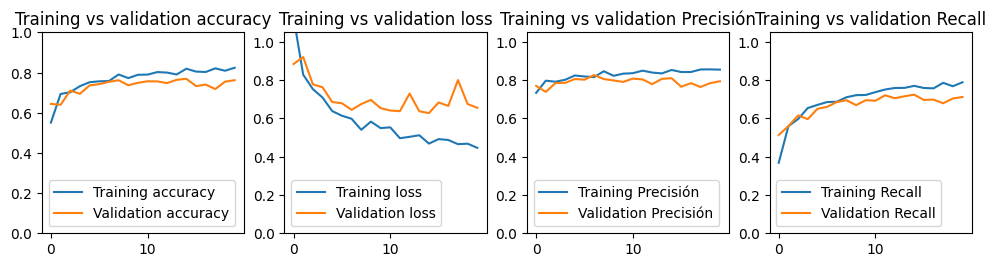

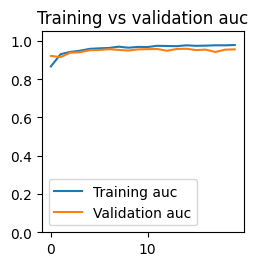

In [ ]:
graph(history1)

39/39 [==============================] - 24s 632ms/step


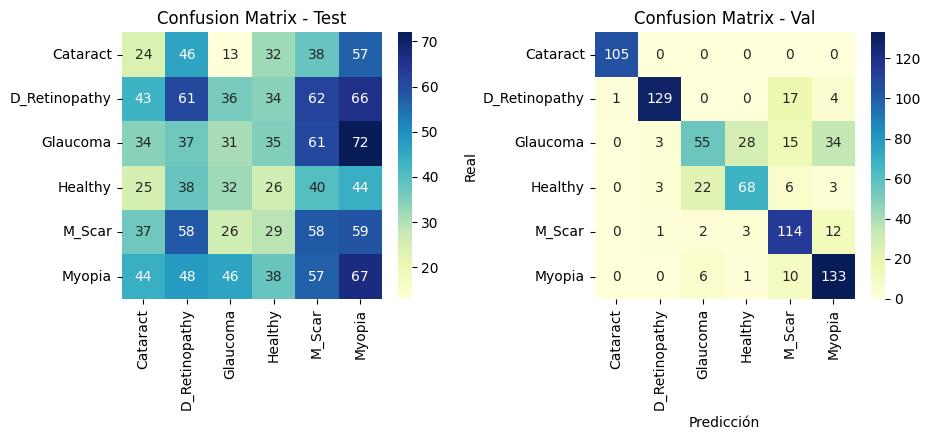

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.11      0.12       210
           1       0.21      0.20      0.21       302
           2       0.17      0.11      0.14       270
           3       0.13      0.13      0.13       205
           4       0.18      0.22      0.20       267
           5       0.18      0.22      0.20       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.95      0.85      0.90       151
           2       0.65      0.41      0.50       135
           3       0.68      0.67      0.67       102
           4       0.70      0.86      0.78       132
           5       0.72      0.89      0.79       150

    accuracy                           0.78       775
   macro avg       0.78

## Modelo 4

In [11]:
base_model4 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 18847430 (71.90 MB)
Trainable params: 52544

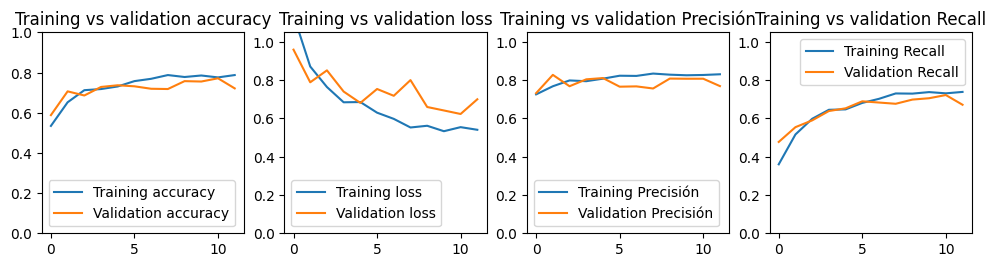

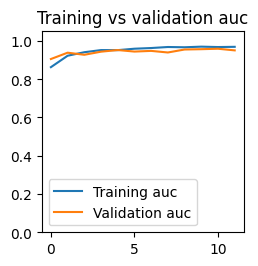

In [12]:
graph(history4)

In [13]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 26s 677ms/step


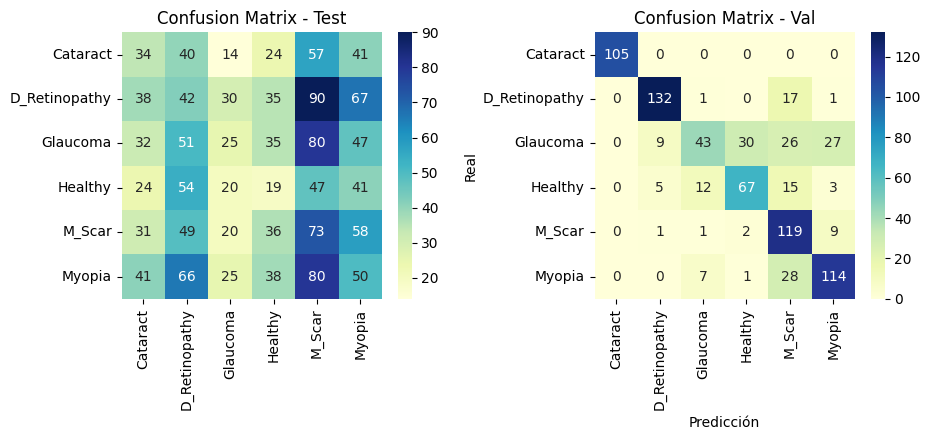

In [14]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [16]:
reporte = calcular_metricas_por_clase(y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.17      0.16      0.17       210
           1       0.14      0.14      0.14       302
           2       0.19      0.09      0.12       270
           3       0.10      0.09      0.10       205
           4       0.17      0.27      0.21       267
           5       0.16      0.17      0.17       300

    accuracy                           0.16      1554
   macro avg       0.16      0.15      0.15      1554
weighted avg       0.16      0.16      0.15      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.90      0.87      0.89       151
           2       0.67      0.32      0.43       135
           3       0.67      0.66      0.66       102
           4       0.58      0.90      0.71       132
           5       0.74      0.76      0.75       150

    accuracy                           0.75       775
   macro avg       0.76

## Modelo 5

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model5 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model5.layers:
    layer.trainable = False

model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))

#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 108s 964ms/step - loss: 1.2269 - accuracy: 0.5005 - precision: 0.7361 - recall: 0.3193 - auc: 0.8436 - val_loss: 1.0299 - val_accuracy: 0.5740 - val_precision: 0.6732 - val_recall: 0.4665 - val_auc: 0.8950
Epoch 2/20
100/100 [==============================] - 88s 888ms/step - loss: 0.9110 - accuracy: 0.6265 - precision: 0.7626 - recall: 0.4915 - auc: 0.9154 - val_loss: 0.8740 - val_accuracy: 0.6763 - val_precision: 0.8123 - val_recall: 0.4595 - val_auc: 0.9262
Epoch 3/20
100/100 [==============================] - 87s 874ms/step - loss: 0.8058 - accuracy: 0.6780 - precision: 0.7674 - recall: 0.5740 - auc: 0.9341 - val_loss: 0.8728 - val_accuracy: 0.6538 - val_precision: 0.7476 - val_recall: 0.5051 - val_auc: 0.9222
Epoch 4/20
100/100 [==============================] - 88s 879ms/step - loss: 0.8025 - accuracy: 0.6815 - precision: 0.7763 - recall: 0.5760 - auc: 0.9347 - val_loss: 0.7462 - val_accuracy: 0.7284 - val_precision: 0.8358 - 

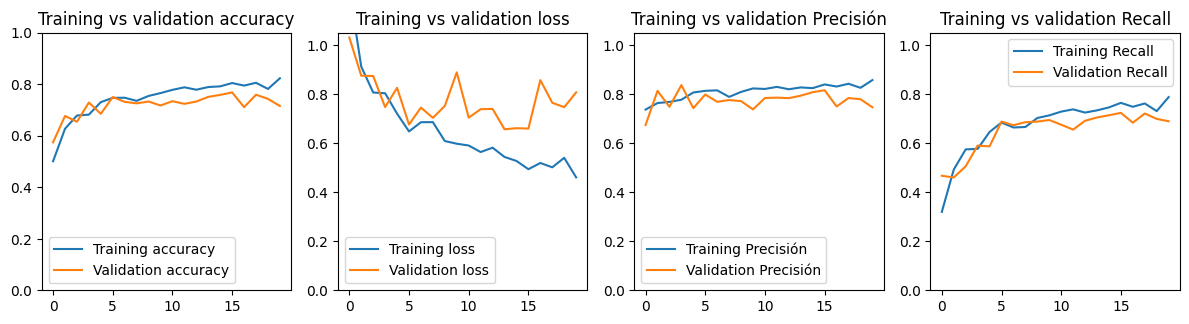

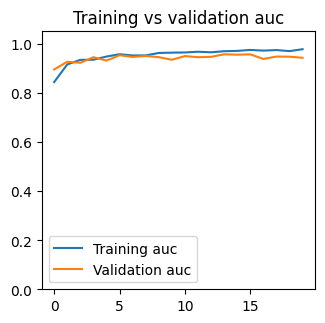

In [ ]:
graph(history5)

39/39 [==============================] - 19s 494ms/step


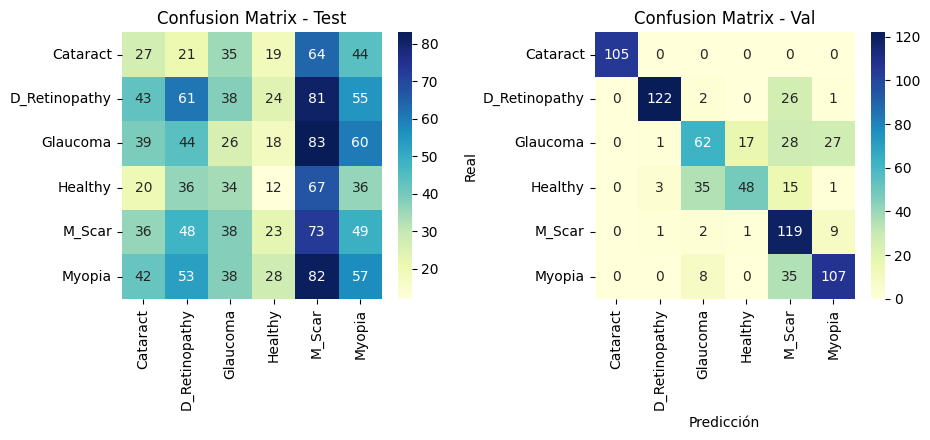

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.23      0.20      0.22       302
           2       0.12      0.10      0.11       270
           3       0.10      0.06      0.07       205
           4       0.16      0.27      0.20       267
           5       0.19      0.19      0.19       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.15      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.96      0.81      0.88       151
           2       0.57      0.46      0.51       135
           3       0.73      0.47      0.57       102
           4       0.53      0.90      0.67       132
           5       0.74      0.71      0.73       150

    accuracy                           0.73       775
   macro avg       0.75

## Modelo 15

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model15 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model15.layers:
    layer.trainable = False

model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 131s 794ms/step - loss: 1.0339 - accuracy: 0.6043 - precision: 0.8132 - recall: 0.3827 - auc: 0.8919 - val_loss: 0.7859 - val_accuracy: 0.7156 - val_precision: 0.8310 - val_recall: 0.5663 - val_auc: 0.9393
Epoch 2/25
150/150 [==============================] - 119s 795ms/step - loss: 0.7130 - accuracy: 0.7219 - precision: 0.8063 - recall: 0.6247 - auc: 0.9489 - val_loss: 0.7087 - val_accuracy: 0.7323 - val_precision: 0.7988 - val_recall: 0.6615 - val_auc: 0.9489
Epoch 3/25
150/150 [==============================] - 115s 767ms/step - loss: 0.6111 - accuracy: 0.7693 - precision: 0.8263 - recall: 0.6900 - auc: 0.9623 - val_loss: 0.6550 - val_accuracy: 0.7709 - val_precision: 0.8099 - val_recall: 0.7021 - val_auc: 0.9554
Epoch 4/25
150/150 [==============================] - 114s 762ms/step - loss: 0.5873 - accuracy: 0.7617 - precision: 0.8155 - recall: 0.7045 - auc: 0.9648 - val_loss: 0.7126 - val_accuracy: 0.7542 - val_precision: 0.8078

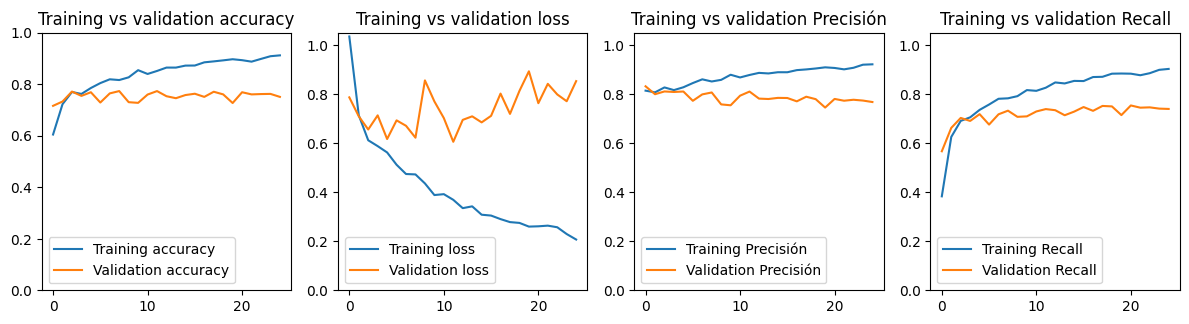

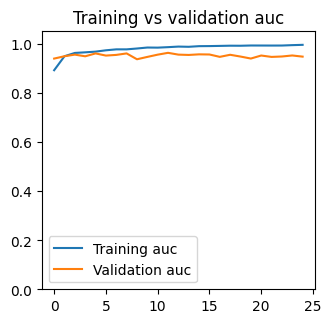

In [ ]:
graph(history15)

39/39 [==============================] - 20s 523ms/step


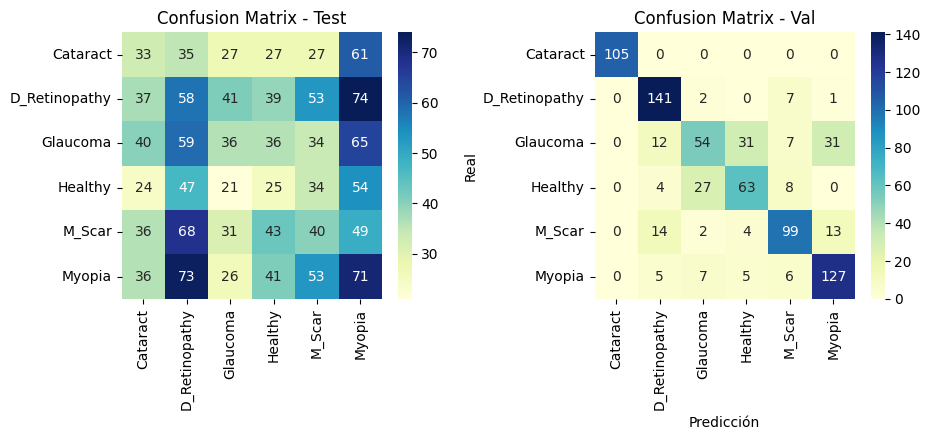

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.16      0.16       210
           1       0.17      0.19      0.18       302
           2       0.20      0.13      0.16       270
           3       0.12      0.12      0.12       205
           4       0.17      0.15      0.16       267
           5       0.19      0.24      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.80      0.93      0.86       151
           2       0.59      0.40      0.48       135
           3       0.61      0.62      0.61       102
           4       0.78      0.75      0.76       132
           5       0.74      0.85      0.79       150

    accuracy                           0.76       775
   macro avg       0.75

## Modelo 16

In [ ]:
base_model16 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_7  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_22 (Dense)            (None, 2056)              3949576   
                                                                 
 dropout (Dropout)           (None, 2056)              0         
                                                                 
 dense_23 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_24 (Dense)            (None, 512)               524800    
                                                      

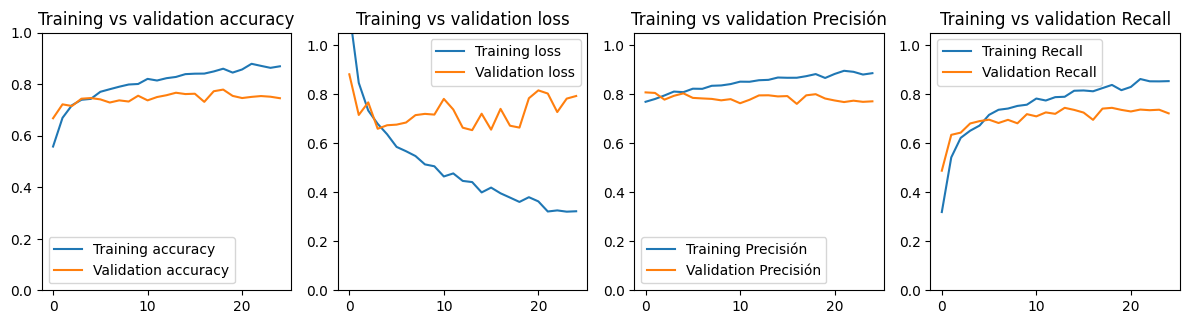

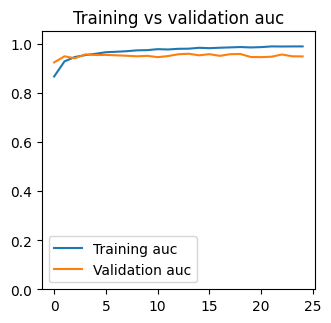

In [ ]:
graph(history16)

39/39 [==============================] - 19s 483ms/step


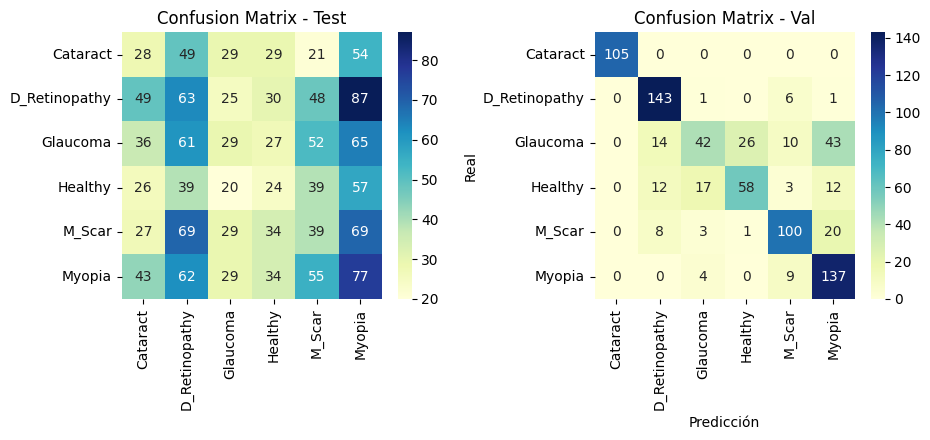

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.18      0.21      0.20       302
           2       0.18      0.11      0.13       270
           3       0.13      0.12      0.13       205
           4       0.15      0.15      0.15       267
           5       0.19      0.26      0.22       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.17      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.81      0.95      0.87       151
           2       0.63      0.31      0.42       135
           3       0.68      0.57      0.62       102
           4       0.78      0.76      0.77       132
           5       0.64      0.91      0.75       150

    accuracy                           0.75       775
   macro avg       0.76

## Modelo 6

In [11]:
base_model6 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5112)              9820152   
                                                                 
 dense_1 (Dense)             (None, 2056)              10512328  
                                                                 
 dense_2 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_3 (Dense)             (None, 512)               52

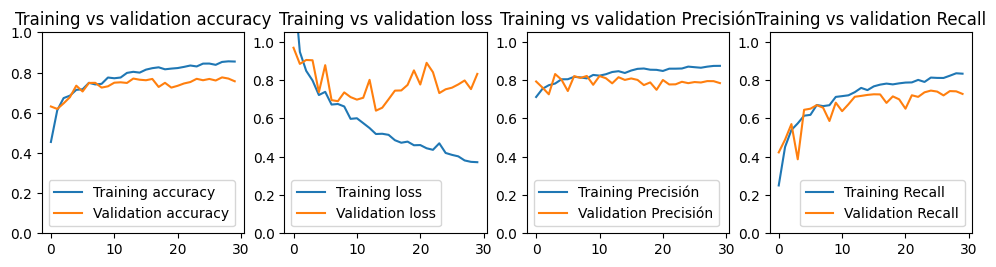

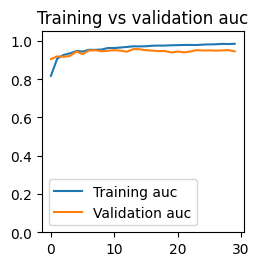

In [12]:
graph(history6)

In [13]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 24s 619ms/step


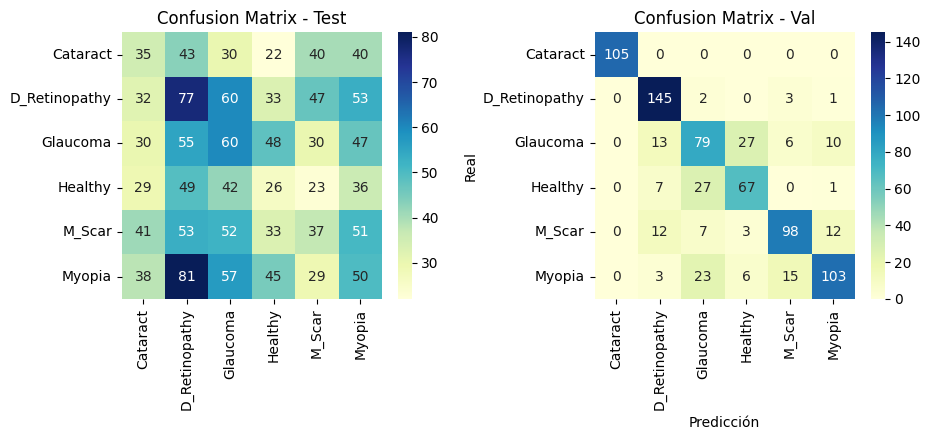

In [14]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [16]:
reporte = calcular_metricas_por_clase(y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       210
           1       0.22      0.25      0.23       302
           2       0.20      0.22      0.21       270
           3       0.13      0.13      0.13       205
           4       0.18      0.14      0.16       267
           5       0.18      0.17      0.17       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.81      0.96      0.88       151
           2       0.57      0.59      0.58       135
           3       0.65      0.66      0.65       102
           4       0.80      0.74      0.77       132
           5       0.81      0.69      0.74       150

    accuracy                           0.77       775
   macro avg       0.77

## Modelo 20

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model20 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model20.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model20.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model20 = Model(inputs=base_model20.input, outputs=predictions)

# Compilar el modelo
model20.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

# Imprimir un resumen del modelo
model20.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model20.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, 230, 230, 3)          0         ['input_10[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_18[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

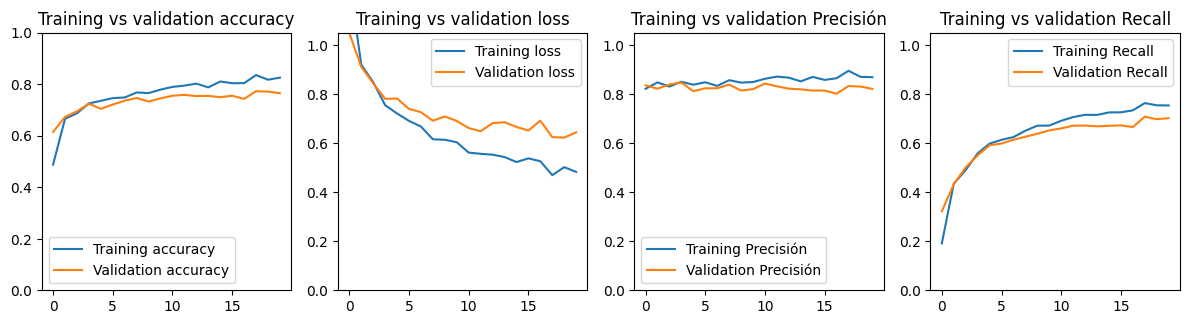

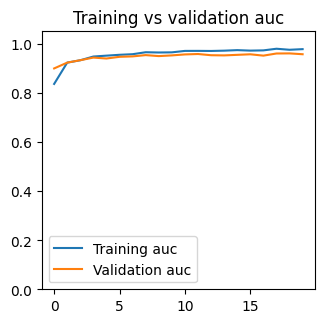

In [ ]:
graph(history_dense)

39/39 [==============================] - 20s 512ms/step


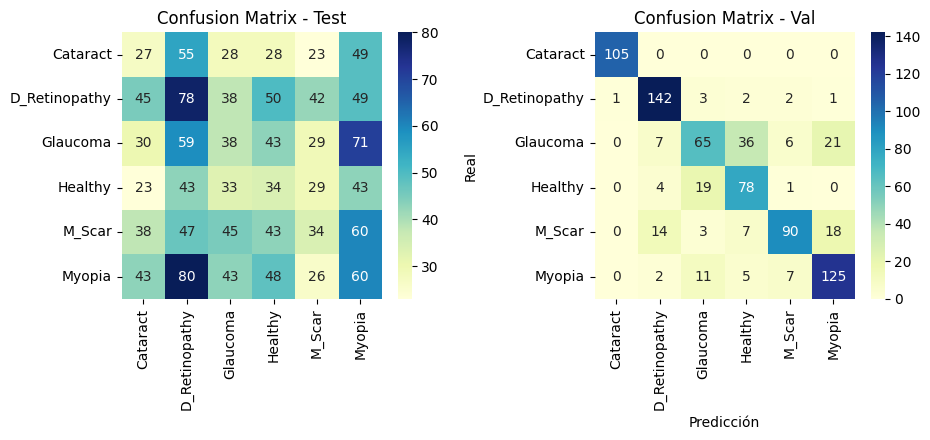

In [ ]:
y_pred_test = model20.predict(test_generator)
y_pred_val = model20.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.22      0.26      0.23       302
           2       0.17      0.14      0.15       270
           3       0.14      0.17      0.15       205
           4       0.19      0.13      0.15       267
           5       0.18      0.20      0.19       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.84      0.94      0.89       151
           2       0.64      0.48      0.55       135
           3       0.61      0.76      0.68       102
           4       0.85      0.68      0.76       132
           5       0.76      0.83      0.79       150

    accuracy                           0.78       775
   macro avg       0.78

## Modelo 19

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 125s 753ms/step - loss: 1.4989 - accuracy: 0.3580 - precision: 0.7919 - recall: 0.0977 - auc: 0.7366 - val_loss: 1.1886 - val_accuracy: 0.4852 - val_precision: 0.7816 - val_recall: 0.2072 - val_auc: 0.8525
Epoch 2/25
150/150 [==============================] - 107s 715ms/step - loss: 1.1668 - accuracy: 0.5193 - precision: 0.7542 - recall: 0.2967 - auc: 0.8562 - val_loss: 0.9644 - val_accuracy: 0.6145 - val_precision: 0.7521 - val_recall: 0.4118 - val_auc: 0.9085
Epoch 3/25
150/150 [==============================] - 111s 741ms/step - loss: 1.0383 - accuracy: 0.5809 - precision: 0.7627 - recall: 0.3877 - auc: 0.8882 - val_loss: 0.8837 - val_accuracy: 0.6628 - val_precision: 0.8057 - val_recall: 0.4350 - val_auc: 0.9247
Epoch 4/25
150/150 [==============================] - 109s 728ms/step - loss: 0.9650 - accuracy: 0.6076 - precision: 0.7662 - recall: 0.4295 - auc: 0.9046 - val_loss: 0.8396 - val_accuracy: 0.6725 - val_precision: 0.7400

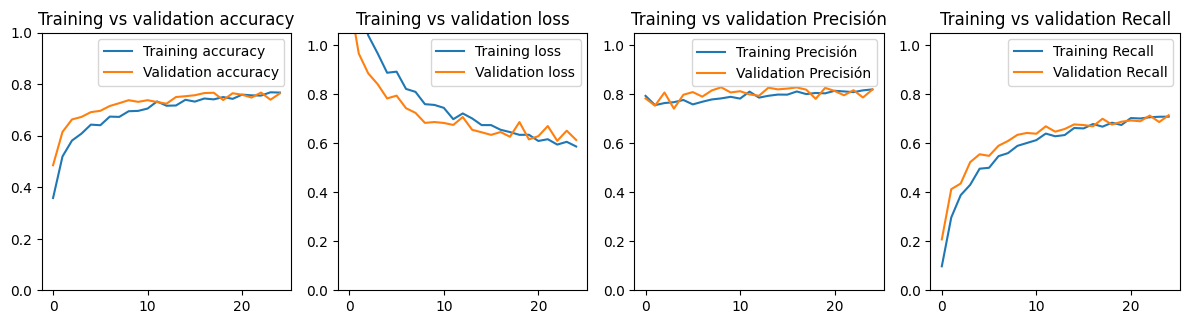

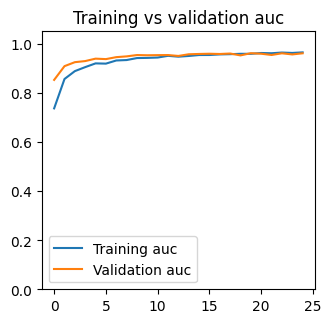

In [ ]:
graph(history19)

39/39 [==============================] - 20s 522ms/step


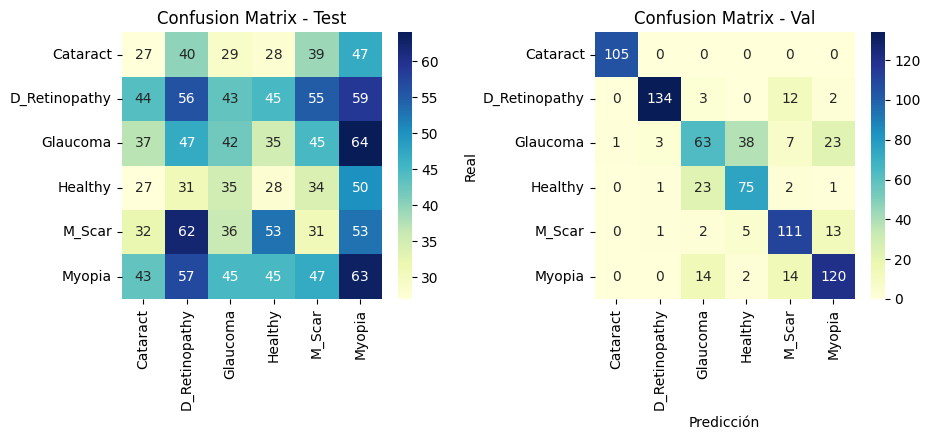

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.19      0.19      0.19       302
           2       0.18      0.16      0.17       270
           3       0.12      0.14      0.13       205
           4       0.12      0.12      0.12       267
           5       0.19      0.21      0.20       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.96      0.89      0.92       151
           2       0.60      0.47      0.52       135
           3       0.62      0.74      0.68       102
           4       0.76      0.84      0.80       132
           5       0.75      0.80      0.78       150

    accuracy                           0.78       775
   macro avg       0.78

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 131s 481ms/step - loss: 0.4056 - accuracy: 0.8428 - precision: 0.8788 - recall: 0.8036 - auc: 0.9828
Evaluar con Validación:
78/78 [==============================] - 39s 493ms/step - loss: 0.6561 - accuracy: 0.7619 - precision: 0.7947 - recall: 0.7124 - auc: 0.9563
Evaluar con Prueba:
39/39 [==============================] - 20s 522ms/step - loss: 0.5471 - accuracy: 0.7794 - precision: 0.8245 - recall: 0.7394 - auc: 0.9681


In [17]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 147s 540ms/step - loss: 0.5025 - accuracy: 0.8023 - precision: 0.8462 - recall: 0.7546 - auc: 0.9739
Evaluar con Validación:
78/78 [==============================] - 40s 510ms/step - loss: 0.7004 - accuracy: 0.7214 - precision: 0.7693 - recall: 0.6718 - auc: 0.9508
Evaluar con Prueba:
39/39 [==============================] - 20s 516ms/step - loss: 0.5995 - accuracy: 0.7484 - precision: 0.7928 - recall: 0.7058 - auc: 0.9637


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 135s 497ms/step - loss: 0.4772 - accuracy: 0.8058 - precision: 0.8354 - recall: 0.7743 - auc: 0.9758
Evaluar con Validación:
78/78 [==============================] - 40s 514ms/step - loss: 0.8063 - accuracy: 0.7149 - precision: 0.7456 - recall: 0.6885 - auc: 0.9426
Evaluar con Prueba:
39/39 [==============================] - 21s 539ms/step - loss: 0.6708 - accuracy: 0.7265 - precision: 0.7574 - recall: 0.6968 - auc: 0.9578


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 133s 489ms/step - loss: 0.2140 - accuracy: 0.9168 - precision: 0.9244 - recall: 0.9032 - auc: 0.9949
Evaluar con Validación:
78/78 [==============================] - 38s 486ms/step - loss: 0.8521 - accuracy: 0.7503 - precision: 0.7669 - recall: 0.7387 - auc: 0.9473
Evaluar con Prueba:
39/39 [==============================] - 19s 495ms/step - loss: 0.7159 - accuracy: 0.7600 - precision: 0.7742 - recall: 0.7432 - auc: 0.9581


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 126s 463ms/step - loss: 0.3201 - accuracy: 0.8700 - precision: 0.8942 - recall: 0.8478 - auc: 0.9891
Evaluar con Validación:
78/78 [==============================] - 37s 472ms/step - loss: 0.7914 - accuracy: 0.7452 - precision: 0.7698 - recall: 0.7207 - auc: 0.9482
Evaluar con Prueba:
39/39 [==============================] - 18s 465ms/step - loss: 0.6617 - accuracy: 0.7548 - precision: 0.7784 - recall: 0.7432 - auc: 0.9630


In [17]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 140s 512ms/step - loss: 0.3781 - accuracy: 0.8474 - precision: 0.8732 - recall: 0.8229 - auc: 0.9845
Evaluar con Validación:
78/78 [==============================] - 40s 514ms/step - loss: 0.8331 - accuracy: 0.7568 - precision: 0.7850 - recall: 0.7284 - auc: 0.9455
Evaluar con Prueba:
39/39 [==============================] - 20s 505ms/step - loss: 0.6611 - accuracy: 0.7703 - precision: 0.7929 - recall: 0.7510 - auc: 0.9579


In [ ]:
evaluar_modelo(model19)

Evaluar con Entrenamiento:
272/272 [==============================] - 131s 480ms/step - loss: 0.4579 - accuracy: 0.8233 - precision: 0.8676 - recall: 0.7693 - auc: 0.9796
Evaluar con Validación:
78/78 [==============================] - 37s 476ms/step - loss: 0.6123 - accuracy: 0.7638 - precision: 0.8177 - recall: 0.7130 - auc: 0.9609
Evaluar con Prueba:
39/39 [==============================] - 19s 483ms/step - loss: 0.5115 - accuracy: 0.7845 - precision: 0.8244 - recall: 0.7329 - auc: 0.9730


In [ ]:
evaluar_modelo(model20)

Evaluar con Entrenamiento:
272/272 [==============================] - 126s 462ms/step - loss: 0.4807 - accuracy: 0.8218 - precision: 0.8687 - recall: 0.7517 - auc: 0.9778
Evaluar con Validación:
78/78 [==============================] - 38s 480ms/step - loss: 0.6434 - accuracy: 0.7645 - precision: 0.8202 - recall: 0.7014 - auc: 0.9570
Evaluar con Prueba:
39/39 [==============================] - 18s 474ms/step - loss: 0.5364 - accuracy: 0.7806 - precision: 0.8391 - recall: 0.7200 - auc: 0.9709
